In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM
%store -r Y_motion_CoM
print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

(12870, 28)
(12870, 2)


# Multivariate Linear Regression (Foot prediction)

The input will use initially only:

- **HighCmd: fwd, side, rot speeds**
- **HighState: fwd, side, rot speeds, footPosition2Body (FR)**

and as output we seek to predict the following:

- **footPosition2Body (FR)**

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [12]:
# Entries where FL foot is swinging
idx_fl_swinging = np.where(X_motion_CoM[:, 25] == 1)[0]
X_motion_CoM_FL_RR = X_motion_CoM[idx_fl_swinging]
Y_motion_CoM_FL_RR = Y_motion_CoM[idx_fl_swinging]

In [13]:
idx_fl_swinging.shape

(6435,)

## Predict FL foot -> x

In [14]:
X_motion_CoM_FL_RR[0, :]

array([0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.166, 0.134, -0.328, 0.203, -0.136,
       -0.338, -0.27, 0.137, -0.339, -0.303, -0.134, -0.328,
       0.00808390155526, -0.000952214873642, -4.08361717042e-39,
       -4.05293539331e-38, -7.08546767602e-22, 0.238485481884, False,
       True, 0.004316108424438636, -0.00044173166939715696], dtype=object)

In [15]:
Y_motion_CoM_FL_RR[0, :]

array([0.028621182573380137, 0.004047596655414683], dtype=object)

### Linear Regression

In [34]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :2], 
               np.array([X_motion_CoM_FL_RR[:, 5]]).T,
               X_motion_CoM_FL_RR[:, 6:8],
               X_motion_CoM_FL_RR[:, 9:11],
               X_motion_CoM_FL_RR[:, 12:14],
               X_motion_CoM_FL_RR[:, 15:17],
               X_motion_CoM_FL_RR[:, 18:20],
               np.array([X_motion_CoM_FL_RR[:, 23]]).T,
               X_motion_CoM_FL_RR[:, 24:26],
               #X_motion_CoM[:, 26:28]))
               np.array([X_motion_CoM_FL_RR[:, 26]]).T))

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_fl_com_x = LinearRegression()

# Fit the model
model_fl_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9020086762280212
RMSE:  0.011772347833967344
The lowest error is:  3.6691379972642046e-06
The highest error is:  0.08118268847791638
The avg. error is:  0.006758458380594301


In [12]:
model_fl_com_x.coef_

array([[ 0.45048643,  0.09691044, -0.07682414,  0.6202241 , -0.3866362 ,
         0.77282733, -0.62556922, -0.80397964,  0.0767963 ,  0.18626835,
         0.61738894]])

In [13]:
model_fl_com_x.intercept_

array([-0.40630527])

In [14]:
model_fl_com_x.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': False,
 'positive': False}

Text(0, 0.5, 'Predictions')

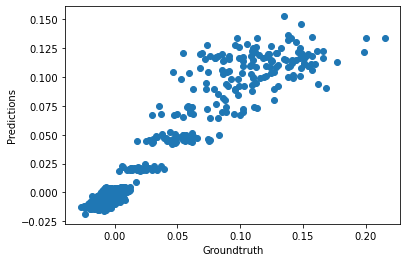

In [35]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [14]:
%store model_fl_com_x

Stored 'model_fl_com_x' (LinearRegression)


In [15]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [16]:
# Save model
joblib.dump(model_fl_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_x.sav")

['/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_x.sav']

## Predict FL foot -> y

### Linear Regression

In [36]:
# Input
#X = np.hstack((X_motion_CoM_FR_RL[:, :2], 
#               np.array([X_motion_CoM_FR_RL[:, 6]]).T,
#               np.array([X_motion_CoM_FR_RL[:, 9]]).T,
#               np.array([X_motion_CoM_FR_RL[:, 12]]).T,
#               np.array([X_motion_CoM_FR_RL[:, 15]]).T))
X = np.hstack((X_motion_CoM_FL_RR[:, :2], 
               np.array([X_motion_CoM_FL_RR[:, 5]]).T,
               X_motion_CoM_FL_RR[:, 6:8],
               X_motion_CoM_FL_RR[:, 9:11],
               X_motion_CoM_FL_RR[:, 12:14],
               X_motion_CoM_FL_RR[:, 15:17],
               X_motion_CoM_FL_RR[:, 18:20],
               np.array([X_motion_CoM_FL_RR[:, 23]]).T,
               X_motion_CoM_FL_RR[:, 24:26],
               #X_motion_CoM[:, 26:28]))
               np.array([X_motion_CoM_FL_RR[:, 27]]).T))

# Label matrix which consists only of
# the next x coordinate of the FR foot.
# We dont consider the first row.
Y = np.array([Y_motion_CoM_FL_RR[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, test_size=0.2, shuffle=True, random_state=100)

# Create the model
model_fl_com_y = LinearRegression()

# Fit the model
model_fl_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9056600163591083
RMSE:  0.011706360450649588
The lowest error is:  2.7778282152002287e-06
The highest error is:  0.0751599320948303
The avg. error is:  0.007515855054065505


In [19]:
model_fl_com_y.coef_

array([[ 3.02611836e-03,  1.07792302e-03,  2.20265817e-03,
         2.47155216e-01, -2.24645310e-01,  7.58895832e-02,
         1.53871816e+00, -5.83361292e-02, -1.58888201e-01,
        -2.36249154e-01, -2.61866859e-01]])

In [20]:
model_fl_com_y.intercept_

array([0.08275039])

Text(0, 0.5, 'Predictions')

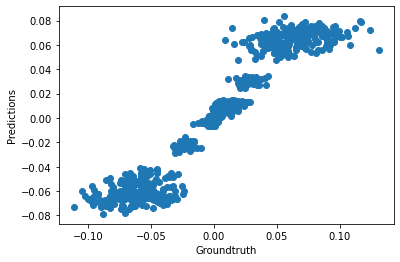

In [37]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [27]:
%store model_fl_com_y

Stored 'model_fl_com_y' (LinearRegression)


In [28]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [29]:
# Save model
joblib.dump(model_fl_com_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_y.sav")

['/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_y.sav']